In [3]:
import sys
sys.path.append("..")

import pandas as pd
from io import BytesIO
from sklearn.metrics import classification_report
import joblib
from ingest.config import get_s3_client, R2_BUCKET
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


In [4]:
s3 = get_s3_client()
response = s3.get_object(Bucket=R2_BUCKET, Key="ml/training_data.parquet")
df = pd.read_parquet(BytesIO(response["Body"].read()))
print(f"Loaded {len(df)} rows")
df.head()

Loaded 7327408 rows


,repo_id,repo_name,stars,forks,pushes,prs,issues,date,avg_stars_7d,avg_forks_7d,avg_pushes_7d,star_velocity,fork_ratio,activity_score,viral,trending
0,966,IoLanguage/io,2,1,0,0,0,2025-12-08,0.000000,0.000000,0.000000,2.000000,0.333333,0,0,0
1,3314,spree/spree,0,0,1,2,0,2025-12-08,0.571429,0.142857,5.142857,0.000000,0.000000,3,0,0
2,5625,phusion/passenger,0,0,1,0,0,2025-12-08,0.400000,0.000000,0.800000,0.000000,0.000000,1,0,0
3,8393,thoughtbot/paperclip,1,0,0,0,0,2025-12-08,0.000000,0.000000,0.000000,1.000000,0.000000,0,0,0
4,8514,rails/rails,3,1,5,2,4,2025-12-08,3.142857,0.571429,5.428571,0.724138,0.250000,11,0,0


In [26]:
df[df["viral"] == 1][["repo_name", "stars", "star_velocity", "fork_ratio"]].head(20)

,repo_name,stars,star_velocity,fork_ratio
16,git/git,16,1.600000,0.117647
139,ohmyzsh/ohmyzsh,12,1.135135,0.076923
375,rust-lang/rust,7,0.636364,0.125000
530,ytdl-org/youtube-dl,6,0.777778,0.142857
546,github/gitignore,4,0.424242,0.200000
1111,torvalds/linux,58,0.754647,0.169492
1530,FortAwesome/Font-Awesome,14,1.719298,0.000000
2544,prometheus/prometheus,4,0.528302,0.000000
2677,trustedsec/social-engineer-toolkit,8,0.205128,0.000000
3393,facebook/react,16,0.568528,0.058824


In [31]:
df[df["trending"] == 1][["repo_name", "stars", "avg_stars_7d", "star_velocity"]].head(20)

,repo_name,stars,avg_stars_7d,star_velocity
212,parallax/jsPDF,1,1.250000,0.444444
217,openzfs/zfs,0,1.285714,0.000000
264,elastic/elasticsearch,1,1.857143,0.350000
324,sympy/sympy,2,1.285714,0.875000
428,nim-lang/Nim,4,1.000000,2.000000
458,gildas-lormeau/SingleFile,6,2.428571,1.750000
461,numpy/numpy,3,3.142857,0.724138
530,ytdl-org/youtube-dl,6,6.714286,0.777778
555,Warzone2100/warzone2100,0,0.400000,0.000000
676,resume/resume.github.com,2,1.333333,0.857143


In [27]:
print("Repos with zero stars:", (df["stars"] == 0).sum())
print("Repos with zero activity:", (df["activity_score"] == 0).sum())

Repos with zero stars: 6905460
Repos with zero activity: 1138088


In [30]:
print(f"Total rows: {len(df)}")
print(f"Viral: {df['viral'].sum()} ({df['viral'].mean()*100:.4f}%)")
print(f"Trending: {df['trending'].sum()} ({df['trending'].mean()*100:.2f}%)")

Total rows: 7327408
Viral: 5978 (0.0816%)
Trending: 13052 (0.18%)


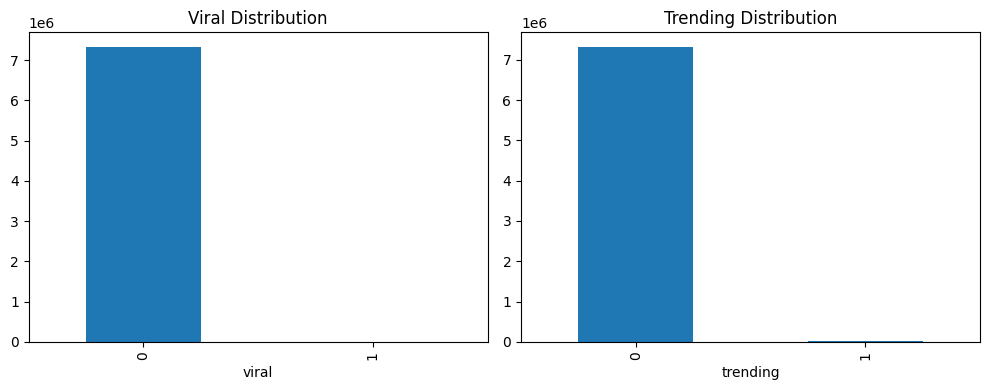

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df["viral"].value_counts().plot(kind="bar", ax=axes[0], title="Viral Distribution")
df["trending"].value_counts().plot(kind="bar", ax=axes[1], title="Trending Distribution")
plt.tight_layout()
plt.show()

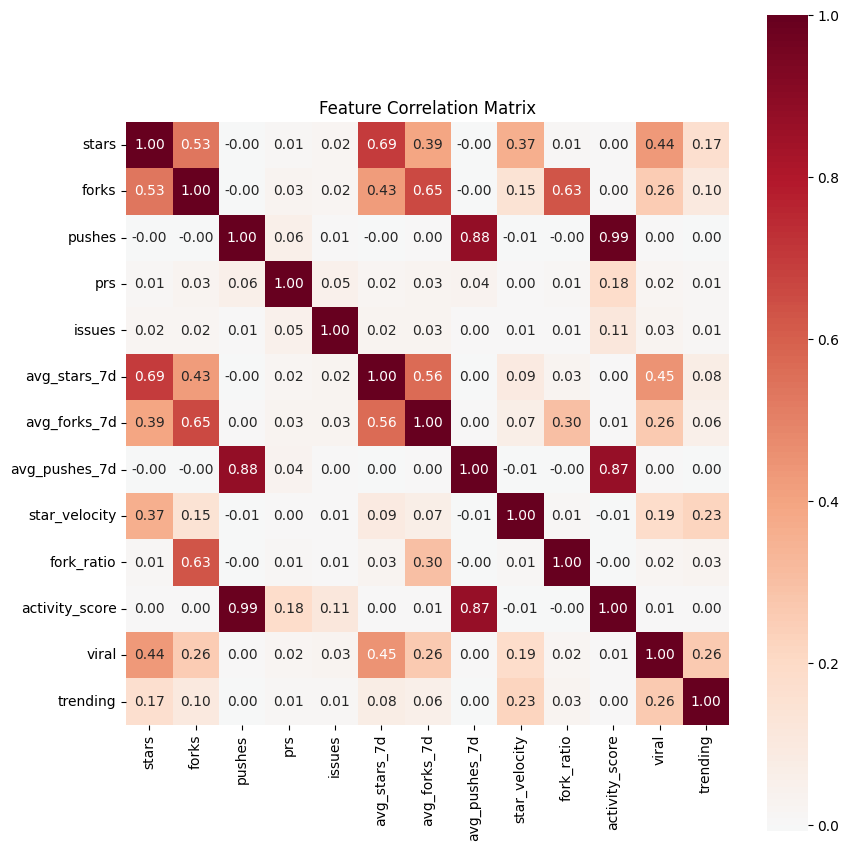

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_cols = ["stars", "forks", "pushes", "prs", "issues", 
                "avg_stars_7d", "avg_forks_7d", "avg_pushes_7d",
                "star_velocity", "fork_ratio", "activity_score",
                "viral", "trending"]

corr_matrix = df[feature_cols].corr()

plt.figure(figsize=(9, 9))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu_r", center=0, fmt=".2f", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [45]:
feature_cols = ["stars", "forks", "pushes", "prs", "issues", 
                "avg_stars_7d", "avg_forks_7d", "avg_pushes_7d",
                "star_velocity", "fork_ratio"]

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df, feature_cols):
    vif_data = pd.DataFrame()
    vif_data["feature"] = feature_cols
    vif_data["VIF"] = [variance_inflation_factor(df[feature_cols].values, i) for i in range(len(feature_cols))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

vif_data = compute_vif(df, feature_cols)
vif_data

,feature,VIF
0,issues,1.004128
1,prs,1.008956
2,star_velocity,1.242280
3,fork_ratio,2.261091
4,avg_forks_7d,2.354813
5,avg_stars_7d,2.672052
6,stars,3.414680
7,forks,4.360932
8,avg_pushes_7d,4.458588
9,pushes,4.468164


In [53]:
viral = df[df["viral"] == 1]
non_viral = df[df["viral"] == 0].sample(frac=0.02, random_state=42)
train_df = pd.concat([viral, non_viral]).sample(frac=1, random_state=42)

X = train_df[feature_cols]
y = train_df["viral"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classification_models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_estimators=100),
    "XGBoost": XGBClassifier(scale_pos_weight=10, n_estimators=100),
    "LGBM": LGBMClassifier(class_weight="balanced", n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(max_iter=500),
}

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "NoScale": None,
}

results = {
    "model": [],
    "scaler": [],
    "f1": [],
    "precision": [],
    "recall": [],
}


In [54]:
for scaler_name, scaler in scalers.items():
    if scaler is None:
        X_train_proc = X_train
        X_test_proc = X_test
    else:
        scaler = scalers[scaler_name].__class__()
        X_train_proc = scaler.fit_transform(X_train)
        X_test_proc = scaler.transform(X_test)
    
    for model_name, model in classification_models.items():
        model_fresh = model.__class__(**model.get_params())
        model_fresh.fit(X_train_proc, y_train)
        y_pred = model_fresh.predict(X_test_proc)
        
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results["model"].append(model_name)
        results["scaler"].append(scaler_name)
        results["f1"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)
        
        # print(f"{scaler_name} | {model_name}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")



[LightGBM] [Info] Number of positive: 4815, number of negative: 117110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1715
[LightGBM] [Info] Number of data points in the train set: 121925, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


d:\UNIVERSITY\1SEM\GitPulse\GitPulse\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4815, number of negative: 117110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 121925, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


d:\UNIVERSITY\1SEM\GitPulse\GitPulse\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4815, number of negative: 117110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 121925, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [55]:
results_df = pd.DataFrame(results)
results_df.sort_values("f1", ascending=False)

,model,scaler,f1,precision,recall
11,MLP,MinMaxScaler,0.914462,0.938462,0.891660
5,MLP,StandardScaler,0.913254,0.935921,0.891660
4,KNN,StandardScaler,0.913234,0.931189,0.895959
10,KNN,MinMaxScaler,0.911481,0.929401,0.894239
16,KNN,NoScale,0.907171,0.928829,0.886500
6,LogisticRegression,MinMaxScaler,0.905188,0.943150,0.870163
17,MLP,NoScale,0.905052,0.917034,0.893379
7,RandomForest,MinMaxScaler,0.889834,0.880471,0.899398
13,RandomForest,NoScale,0.883602,0.873216,0.894239
1,RandomForest,StandardScaler,0.883227,0.872483,0.894239


In [59]:
viral = df[df["viral"] == 1]
non_viral = df[df["viral"] == 0].sample(frac=0.02, random_state=42)
balanced_df = pd.concat([viral, non_viral]).sample(frac=1, random_state=42)

X = balanced_df[feature_cols]
y = balanced_df["viral"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = MLPClassifier(max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

print("Performance on held-out test set:")
print(classification_report(y_test, model.predict(X_test_scaled)))

full_X_scaled = scaler.transform(df[feature_cols])
df["viral_pred"] = model.predict(full_X_scaled)
df["viral_prob"] = model.predict_proba(full_X_scaled)[:, 1]

print(f"\nPredicted viral: {df['viral_pred'].sum()}")
print(f"Actual viral: {df['viral'].sum()}")

Performance on held-out test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29319
           1       0.94      0.89      0.91      1163

    accuracy                           0.99     30482
   macro avg       0.97      0.94      0.96     30482
weighted avg       0.99      0.99      0.99     30482


Predicted viral: 19225
Actual viral: 5978


In [67]:
df[["repo_name", "stars", "avg_stars_7d", "star_velocity", "viral",'viral_pred', "viral_prob"]].sort_values("viral_prob", ascending=False)

,repo_name,stars,avg_stars_7d,star_velocity,viral,viral_pred,viral_prob
6873794,datawhalechina/hello-agents,151,195.428571,0.768727,1,1,1.000000e+00
6871660,facebookresearch/sam-audio,72,0.000000,72.000000,1,1,1.000000e+00
3770750,sarwarbeing-ai/Agentic_Design_Patterns,20,199.857143,0.099573,1,1,1.000000e+00
3770879,datawhalechina/hello-agents,184,113.857143,1.601990,1,1,1.000000e+00
7111671,eooce/Gla-deploy,42,138.333333,0.301435,1,1,1.000000e+00
...,...,...,...,...,...,...,...
3125195,Flo-App-bxl/TDID-Live,0,0.000000,0.000000,0,0,2.829980e-07
2562796,octocat/Hello-World,0,6.142857,0.000000,0,0,4.140257e-08
357334,trunk-io/mergequeue-demo,0,0.000000,0.000000,0,0,3.596801e-09
5402697,dravenox/lel,0,0.000000,0.000000,0,0,7.073508e-11


In [66]:
print("Performance on FULL dataset:")
print(classification_report(df["viral"], df["viral_pred"]))

Performance on FULL dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7321430
           1       0.27      0.88      0.42      5978

    accuracy                           1.00   7327408
   macro avg       0.64      0.94      0.71   7327408
weighted avg       1.00      1.00      1.00   7327408



In [ ]:
import joblib

joblib.dump(model, "model_viral.pkl")
joblib.dump(scaler, "scaler_viral.pkl")


Saved


In [6]:
model = joblib.load("model_viral.pkl")
scaler = joblib.load("scaler_viral.pkl")

feature_cols = ["stars", "forks", "pushes", "prs", "issues",
                "avg_stars_7d", "avg_forks_7d", "avg_pushes_7d",
                "star_velocity", "fork_ratio"]

X = df[feature_cols]
X_scaled = scaler.transform(X)

df["viral_prob"] = model.predict_proba(X_scaled)[:, 1]
df["viral_pred"] = (df["viral_prob"] >= 0.7).astype(int)

print(f"Predicted viral: {df['viral_pred'].sum()}")
print(f"Actual viral: {df['viral'].sum()}")
print("\nPerformance:")
print(classification_report(df["viral"], df["viral_pred"]))


Predicted viral: 13665
Actual viral: 5978

Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7321430
           1       0.37      0.85      0.51      5978

    accuracy                           1.00   7327408
   macro avg       0.69      0.92      0.76   7327408
weighted avg       1.00      1.00      1.00   7327408



In [4]:
feature_cols = ["stars", "forks", "pushes", "prs", "issues",
                "avg_stars_7d", "avg_forks_7d", "avg_pushes_7d",
                "star_velocity", "fork_ratio"]

trending = df[df["trending"] == 1]
non_trending = df[df["trending"] == 0].sample(frac=0.02, random_state=42)
train_df = pd.concat([trending, non_trending]).sample(frac=1, random_state=42)

print(f"Trending: {len(trending)}, Non-trending: {len(non_trending)}, Total: {len(train_df)}")

X = train_df[feature_cols]
y = train_df["trending"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classification_models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_estimators=100),
    "XGBoost": XGBClassifier(scale_pos_weight=10, n_estimators=100),
    "LGBM": LGBMClassifier(class_weight="balanced", n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(max_iter=500),
}

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "NoScale": None,
}

results = {
    "model": [],
    "scaler": [],
    "f1": [],
    "precision": [],
    "recall": [],
}



Trending: 13052, Non-trending: 146287, Total: 159339


In [5]:

for scaler_name, scaler in scalers.items():
    if scaler is None:
        X_train_proc = X_train
        X_test_proc = X_test
    else:
        scaler = scalers[scaler_name].__class__()
        X_train_proc = scaler.fit_transform(X_train)
        X_test_proc = scaler.transform(X_test)
    
    for model_name, model in classification_models.items():
        model_fresh = model.__class__(**model.get_params())
        model_fresh.fit(X_train_proc, y_train)
        y_pred = model_fresh.predict(X_test_proc)
        
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results["model"].append(model_name)
        results["scaler"].append(scaler_name)
        results["f1"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)
        
        print(f"{scaler_name} | {model_name}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

results_df = pd.DataFrame(results)
results_df.sort_values("f1", ascending=False)

StandardScaler | LogisticRegression: F1=0.7146, Precision=0.5840, Recall=0.9203
StandardScaler | RandomForest: F1=0.7881, Precision=0.7283, Recall=0.8586
StandardScaler | XGBoost: F1=0.7897, Precision=0.6896, Recall=0.9238
[LightGBM] [Info] Number of positive: 10442, number of negative: 117029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 127471, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


d:\UNIVERSITY\1SEM\GitPulse\GitPulse\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


StandardScaler | LGBM: F1=0.7748, Precision=0.6623, Recall=0.9333
StandardScaler | KNN: F1=0.7963, Precision=0.7786, Recall=0.8149
StandardScaler | MLP: F1=0.8312, Precision=0.8449, Recall=0.8180
MinMaxScaler | LogisticRegression: F1=0.6936, Precision=0.7031, Recall=0.6843
MinMaxScaler | RandomForest: F1=0.7915, Precision=0.7340, Recall=0.8586
MinMaxScaler | XGBoost: F1=0.7897, Precision=0.6896, Recall=0.9238
[LightGBM] [Info] Number of positive: 10442, number of negative: 117029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1469
[LightGBM] [Info] Number of data points in the train set: 127471, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


d:\UNIVERSITY\1SEM\GitPulse\GitPulse\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


MinMaxScaler | LGBM: F1=0.7764, Precision=0.6644, Recall=0.9337
MinMaxScaler | KNN: F1=0.7961, Precision=0.7877, Recall=0.8046
MinMaxScaler | MLP: F1=0.8322, Precision=0.8202, Recall=0.8444
NoScale | LogisticRegression: F1=0.7146, Precision=0.5840, Recall=0.9203
NoScale | RandomForest: F1=0.7902, Precision=0.7330, Recall=0.8571
NoScale | XGBoost: F1=0.7897, Precision=0.6896, Recall=0.9238
[LightGBM] [Info] Number of positive: 10442, number of negative: 117029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1469
[LightGBM] [Info] Number of data points in the train set: 127471, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
NoScale | LGBM: F1=0.7764, Precision=0.6644, Rec

,model,scaler,f1,precision,recall
11,MLP,MinMaxScaler,0.832169,0.820246,0.844444
5,MLP,StandardScaler,0.831224,0.844875,0.818008
17,MLP,NoScale,0.829908,0.848339,0.812261
4,KNN,StandardScaler,0.796331,0.778551,0.814943
10,KNN,MinMaxScaler,0.796058,0.787697,0.804598
7,RandomForest,MinMaxScaler,0.791453,0.734032,0.858621
13,RandomForest,NoScale,0.790180,0.732962,0.857088
8,XGBoost,MinMaxScaler,0.789715,0.689645,0.923755
14,XGBoost,NoScale,0.789715,0.689645,0.923755
2,XGBoost,StandardScaler,0.789715,0.689645,0.923755


In [7]:
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import classification_report

model_trending = XGBClassifier(scale_pos_weight=10, n_estimators=100, random_state=42)
model_trending.fit(X_train, y_train)

full_X = df[feature_cols]
df["trending_prob"] = model_trending.predict_proba(full_X)[:, 1]
df["trending_pred"] = (df["trending_prob"] >= 0.99).astype(int)

print(f"Predicted trending: {df['trending_pred'].sum()}")
print(f"Actual trending: {df['trending'].sum()}")
print("\nPerformance on full dataset:")
print(classification_report(df["trending"], df["trending_pred"]))

joblib.dump(model_trending, "model_trending_stratified.pkl")
# joblib.dump(scaler_trending, "scaler_trending.pkl")


Predicted trending: 19259
Actual trending: 13052

Performance on full dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7314356
           1       0.25      0.37      0.30     13052

    accuracy                           1.00   7327408
   macro avg       0.63      0.69      0.65   7327408
weighted avg       1.00      1.00      1.00   7327408



['model_trending_stratified.pkl']

In [6]:
scaler_trending = MinMaxScaler()
X_train_scaled = scaler_trending.fit_transform(X_train)

model_trending = MLPClassifier(max_iter=500, random_state=42)
model_trending.fit(X_train_scaled, y_train)

full_X = df[feature_cols]
full_X_scaled = scaler_trending.transform(full_X)

df["trending_prob"] = model_trending.predict_proba(full_X_scaled)[:, 1]
df["trending_pred"] = (df["trending_prob"] >= 0.85).astype(int)

print(f"Predicted trending: {df['trending_pred'].sum()}")
print(f"Actual trending: {df['trending'].sum()}")
print("\nPerformance on full dataset:")
print(classification_report(df["trending"], df["trending_pred"]))

joblib.dump(model_trending, "model_trending_stratified.pkl")
joblib.dump(scaler_trending, "scaler_trending_stratified.pkl")


Predicted trending: 17198
Actual trending: 13052

Performance on full dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7314356
           1       0.26      0.34      0.29     13052

    accuracy                           1.00   7327408
   macro avg       0.63      0.67      0.65   7327408
weighted avg       1.00      1.00      1.00   7327408



['scaler_trending_stratified.pkl']